In [82]:
from brian2 import *
import random
%matplotlib inline
apl_enable = False

In [83]:
start_scope()

In [84]:
#PN Terminal Identity
tau_pn = 5*ms
V0_pn = -60*mV
Vth_pn = -45*mV
Vres_pn = -80*mV
I_pn = 0*mV/ms
eqs_pn = '''
dv/dt = (V0_pn-v)/tau_pn + I_pn: volt
'''
G_pn = NeuronGroup(1440, eqs_pn, threshold='v>Vth_pn', reset='v=Vres_pn', refractory=1*ms, method='linear') #method='Euler' linear
G_pn.v = -80*mV # initial value(如何确定的？多大程度上影响结果？)

In [85]:
debug = False
if debug:
    M_pn_stat = StateMonitor(G_pn, 'v', record=0)
    M_pn_spk = SpikeMonitor(G_pn)
    run(50*ms)
    figure(figsize=(12,4))
    subplot(121)
    plot(M_pn_stat.t/ms, M_pn_stat.v[0])
    xlabel('Time (ms)')
    ylabel('v');
    title('M_PN_V')
    subplot(122)
    plot(M_pn_spk.t/ms, M_pn_spk.i, '.k')
    xlabel('Time (ms)')
    ylabel('Neuron index');
    title('M_PN_SPK')

In [86]:
#KC Ientity
tau_kc = 5*ms
V0_kc = -55*mV
Vth_kc = -36*mV
Vres_kc = -60*mV
eqs_kc = '''
dv/dt = (V0_kc-v)/tau_kc : volt
'''
G_kc = NeuronGroup(2500, eqs_kc, threshold='v>Vth_kc', reset='v=Vres_kc', refractory=1*ms, method='Euler') #method='Euler' linear
G_kc.v = -80*mV # initial value

In [87]:
debug = False
if debug:
    M_kc_stat = StateMonitor(G_kc, 'v', record=0)
    M_kc_spk = SpikeMonitor(G_kc)
    run(50*ms)
    figure(figsize=(12,4))
    subplot(121)
    plot(M_kc_stat.t/ms, M_kc_stat.v[0])
    xlabel('Time (ms)')
    ylabel('v');
    title('M_KC_V')
    subplot(122)
    plot(M_kc_spk.t/ms, M_kc_spk.i, '.k')
    xlabel('Time (ms)')
    ylabel('Neuron index');
    title('M_KC_SPK')

In [ ]:
#APL Identity
C = 0.1*nF #APL 电容
g_leak = 0.2*uS #KC对APL的突触电导
V_leak = -60*mV 
g_aplkc = 50*nS #APL对AKC的突触电导
V_rev = -90*mV #Reversal Potential
V_mid = -40*mV #Activation curve parameters
V_slope = 5*mV #Activation curve parameters
tau_apl = 4*ms
eqs_apl = '''
dv/dt =（I_syn - g_leak(V - V_leak)）/ C : volt
I_syn = g_aplkc * S*(V-V_rev) : amp
dS/dt = (S_inf - S)/tau_apl : 1
S_inf = 1/(1+exp((V_mid - Vpre)/V_slope)): 1

'''
G_apl = NeuronGroup(1, eqs_apl,) #method='Euler' linearS_pn_kc = Synapses(G_pn, G_kc, 'w : volt', on_pre='v_post += w')

In [88]:
tau_apl = 5*ms
V0_apl = -60*mV  # attractors
Vth_apl = -45*mV
Vres_apl = -80*mV 
eqs_apl = '''
dv/dt = (V0_apl-v)/tau_apl : volt
'''
G_apl = NeuronGroup(1, eqs_apl, threshold='v>Vth_apl', reset='v=Vres_apl', refractory=1*ms, method='Euler') #method='Euler' linear
G_apl.v = -30*mV # initial value

In [89]:
#PN-KC Connect Pattern
S_pn_kc = Synapses(G_pn, G_kc, 'w : volt', on_pre='v_post += w')
propertion = 0.6 # the big Pn proportion in source group
bigPn = np.arange( 0, int(propertion*G_pn.N), 1) 
smallPn = np.arange( int(propertion*G_pn.N), G_pn.N, 1) 

arrayi = []
arrayj = []

for i in range(G_pn.N):
    if i in bigPn:
        ifrom = [i]*15
        ito = [random.randint(0,G_kc.N-1) for _ in range(15)]
    else:
        ifrom = [i]*12
        ito = [random.randint(0,G_kc.N-1) for _ in range(12)]
    arrayi.extend(ifrom)
    arrayj.extend(ito)
# arrayi = [int(i) for i in arrayi]
# arrayj = [int(j) for j in arrayj]
S_pn_kc.connect(i=arrayi, j=arrayj)
S_pn_kc.w = '10*mV’

In [90]:
print('The mean inputs of KC neuron is:'+str(len(S_pn_kc.i)/G_kc.N))

The mean inputs of KC neuron is:7.9488


In [91]:
debug = False
if debug:
    M_pn = StateMonitor(G_pn, 'v', record=0)
    M_kc = StateMonitor(G_kc, 'v', record=0)

    run(50*ms)

    figure()
    subplot(121)
    plot(M_pn.t/ms, M_pn.v[0])
    xlabel('Time (ms)')
    ylabel('v');
    subplot(122)
    plot(M_kc.t/ms, M_kc.v[0])
    xlabel('Time (ms)')
    ylabel('v');

In [92]:
#KC TO apl Synapse
S_kc_apl = Synapses(G_kc, G_apl, 'w : volt', on_pre='v_post += w')
S_kc_apl.connect() # connect all-to-all
S_kc_apl.w = '2*mV'

In [93]:
#apl to KC Synapse
S_apl_kc = Synapses(G_apl, G_kc, 'w : volt', on_pre='v_post -= w')
S_apl_kc.connect() # connect all-to-all
if apl_enable:
    S_apl_kc.w = '2*mV'
else:
    S_apl_kc.w = '0*mV'

In [94]:
#apl to PN Terminal synapse
S_apl_pn = Synapses(G_apl, G_pn, 'w : volt', on_pre='v_post -= w')
S_apl_pn.connect() # connect all-to-all
for j in range(G_pn.N):
    if apl_enable:
        if j in bigPn:
            S_apl_pn.w[0,j] = '5*mV'
        else:
            S_apl_pn.w[0,j] = '1*mV'
    else:
        S_apl_pn.w[0,j] = '0*mV'

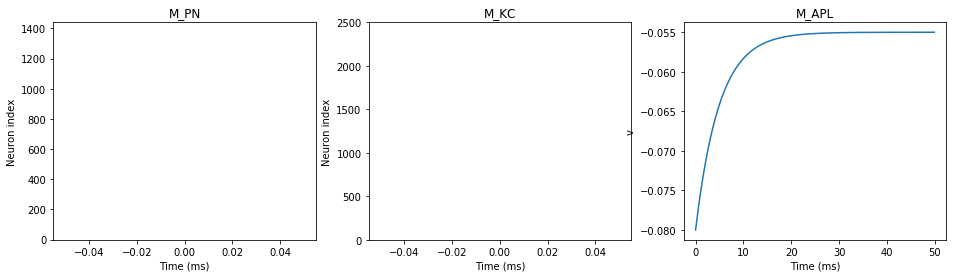

In [95]:
debug = True
if debug:
    M_pn = SpikeMonitor(G_pn)
    M_kc = SpikeMonitor(G_kc)
    M_apl = StateMonitor(G_kc, 'v', record=0)

    run(50*ms)

    figure(figsize=(16,4))
    subplot(131)
    plot(M_pn.t/ms, M_pn.i, '.k')
    xlabel('Time (ms)')
    ylabel('Neuron index');
    ylim(-1, G_pn.N)
    title('M_PN')
    subplot(132)
    plot(M_kc.t/ms, M_kc.i, '.k')
    xlabel('Time (ms)')
    ylabel('Neuron index');
    ylim(-1, G_kc.N)
    title('M_KC')
    subplot(133)
    plot(M_apl.t/ms, M_apl.v[0])
    xlabel('Time (ms)')
    ylabel('v');
    title('M_APL')

NameError: name 'duration' is not defined

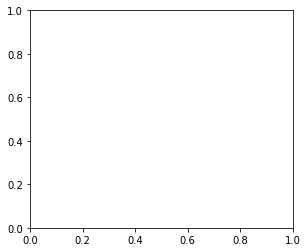

In [96]:
debug = True
if debug:
    figure(figsize=(16,4))
    subplot(131)
    plot(M_pn.count/duration)
    xlabel('Neuron')
    ylabel('Neuron Frequency');
    # ylim(-1, G_pn.N)
    title('M_PN')
    subplot(132)
    plot(M_kc.count/duration)
    xlabel('Neuron')
    ylabel('Neuron Frequency');
    # ylim(-1, G_kc.N)
    title('M_KC')
    subplot(133)
    plot(M_apl.t/ms, M_apl.v[0])
    xlabel('Time (ms)')
    ylabel('v');
    title('M_APL')